# SE3

In [40]:
import sys
sys.path.append('..')
import numpy as np
import jax
import jax.numpy as jnp
from traoptlibrary.traopt_utilis import se3_hat, quatpos2SE3
from scipy.linalg import expm, logm

dt = 0.05
Nsim = 200

quat0_ref = np.array([1, 0, 0, 0])
p0_ref = np.array([0, 0, 0])
w0_ref = np.array([0, 0, 1]) * 1
v0_ref = np.array([1, 0, 0.1]) * 2

q0_ref = quatpos2SE3( np.concatenate((quat0_ref, p0_ref)) )
xi0_ref = np.concatenate((w0_ref, v0_ref))

q_ref = np.zeros((Nsim + 1, 4, 4))  # SE(3)
q_ref[0] = q0_ref
xi_ref = np.zeros((Nsim + 1, 6,)) 
xi_ref[0] = xi0_ref

X = q0_ref.copy()

for i in range(Nsim):

    xi_ref_rt = xi0_ref.copy()
    X = X @ expm( se3_hat( xi_ref_rt ) * dt)

    xi_ref_rt[0] = np.sin(i / 20) * 2
    xi_ref_rt[4] = np.cos(np.sqrt(i)) * 1
    xi_ref_rt[5] = 1  # np.sin(np.sqrt(i)) * 1

    q_ref[i + 1] = X.copy()
    xi_ref[i + 1] = xi_ref_rt.copy()


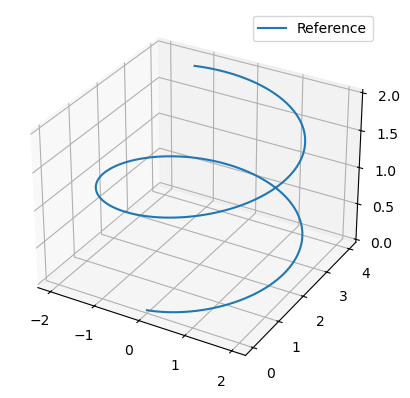

In [41]:
import matplotlib.pyplot as plt
pos_ref = np.array([x[:3,3] for x in q_ref]).reshape(Nsim+1, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_ref[:, 0], pos_ref[:, 1], pos_ref[:, 2],
            label='Reference')
plt.legend()

In [15]:
file_name = 'optimized_trajectories/path_se3_spiral_static_velocity'

with open(file_name+'.npy', 'wb') as f:
    np.save(f, q_ref)
    np.save(f, xi_ref)
    np.save(f, dt)

In [12]:
import sys
sys.path.append('..')
import numpy as np
import jax
import jax.numpy as jnp
from traoptlibrary.traopt_utilis import se3_hat, quatpos2SE3
from scipy.linalg import expm, logm

dt = 0.05
Nsim = 200

quat0_ref = np.array([1, 0, 0, 0])
p0_ref = np.array([0, 0, 0])
w0_ref = np.array([0, 0, 1]) * 1
v0_ref = np.array([1, 0, 0.1]) * 2

q0_ref = quatpos2SE3( np.concatenate((quat0_ref, p0_ref)) )
xi0_ref = np.concatenate((w0_ref, v0_ref))

q_ref = np.zeros((Nsim + 1, 4, 4))  # SE(3)
q_ref[0] = q0_ref
xi_ref = np.zeros((Nsim + 1, 6,)) 
xi_ref[0] = xi0_ref

X = q0_ref.copy()

for i in range(Nsim):

    xi_ref_rt = xi0_ref.copy()

    xi_ref_rt[0] = np.sin(i / 20 / 10) * 2
    xi_ref_rt[1] = np.cos(i / 20 / 5) * 2
    # xi_ref_rt[2] = np.sin(i / 5) * 2
    xi_ref_rt[4] = np.cos(i/20 * 2) * 1
    xi_ref_rt[5] = np.sin(i/20 * 1) * 1

    X = X @ expm( se3_hat( xi_ref_rt ) * dt)
    
    q_ref[i + 1] = X.copy()
    xi_ref[i + 1] = xi_ref_rt.copy()


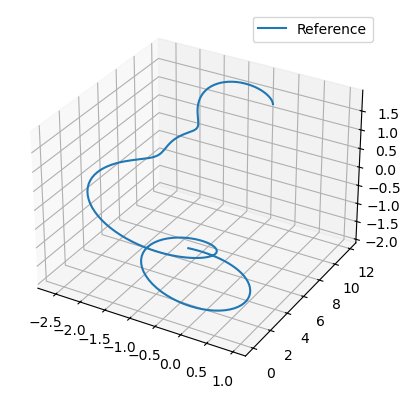

In [14]:
import matplotlib.pyplot as plt
pos_ref = np.array([x[:3,3] for x in q_ref]).reshape(Nsim+1, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_ref[:, 0], pos_ref[:, 1], pos_ref[:, 2],
            label='Reference')
plt.legend()

In [5]:
file_name = 'optimized_trajectories/path_se3_generate_sine_3'

with open(file_name+'.npy', 'wb') as f:
    np.save(f, q_ref)
    np.save(f, xi_ref)
    np.save(f, dt)

# Drone Racing

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_name = 'optimized_trajectories/path_dense_random_columns_4obj'
# file_name = 'optimized_trajectories/path_dense_random_columns'
file_path = file_name + '.csv'
df = pd.read_csv(file_path)

dt = 0.004

N = df.shape[0] # horizon+1
q_ref = np.empty(( N, 4, 4 ))
xi_ref = np.empty(( N, 6, ))

df.columns

Index(['t', 'p_x', 'p_y', 'p_z', 'q_w', 'q_x', 'q_y', 'q_z', 'v_x', 'v_y',
       'v_z', 'w_x', 'w_y', 'w_z', 'a_lin_x', 'a_lin_y', 'a_lin_z', 'u_1',
       'u_2', 'u_3', 'u_4', 'comm_t', 'comm_id', 'comm_type'],
      dtype='object')

Ultimate goal is to obtain `q_ref`, `xi_ref`

In [12]:
import sys
sys.path.append('..')
from traoptlibrary.traopt_utilis import quat2rotm, quatpos2SE3, rotm2euler

position_columns = ['p_x', 'p_y', 'p_z']
quaternion_columns = ['q_w', 'q_x', 'q_y', 'q_z']
quaternion_columns_xyzw = ['q_x', 'q_y', 'q_z', 'q_w']
pos = df[ position_columns ].to_numpy()
quat = df[ quaternion_columns ].to_numpy()
quat_xyzw = df[quaternion_columns_xyzw].to_numpy()
romt = np.array([ quat2rotm(x) for x in quat ])
quatpos = df[quaternion_columns + position_columns].to_numpy()
q_ref = np.array([ quatpos2SE3(x) for x in quatpos ])

translation_velocity_columns = ['v_x', 'v_y', 'v_z']
v_world = df[translation_velocity_columns].to_numpy()
v_ref = np.array([ romt[i].T @ (v_world[i].reshape(3,1)) for i in range(N) ]).reshape(N, 3)
xi_ref[:,3:] = v_ref.copy()

angular_velocity_columns = ['w_x', 'w_y', 'w_z']
w = df[angular_velocity_columns].to_numpy()
xi_ref[:,:3] = w.copy()

angle_euler = np.array([ rotm2euler(x) for x in romt ] )

In [13]:
with open(file_name+'.npy', 'wb') as f:
    np.save(f, q_ref)
    np.save(f, xi_ref)
    np.save(f, dt)

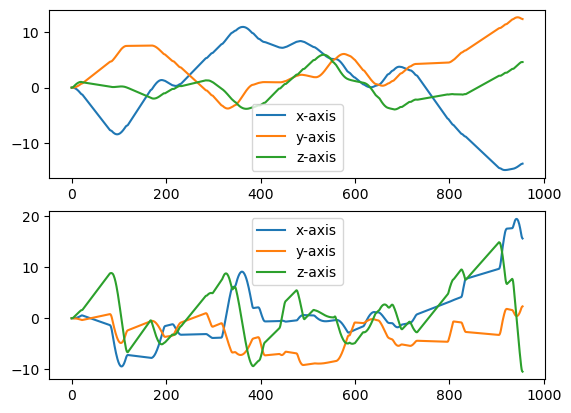

In [10]:
plt.figure()
plt.subplot(211)
plt.plot( v_world, label=['x-axis','y-axis','z-axis'] )
plt.legend()

plt.subplot(212)
plt.plot( v_ref, label=['x-axis','y-axis','z-axis'] )
plt.legend()

plt.show()

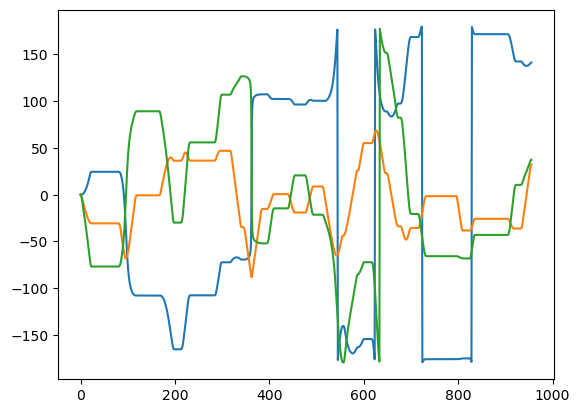

In [9]:
plt.figure()
plt.plot( angle_euler )
plt.show()

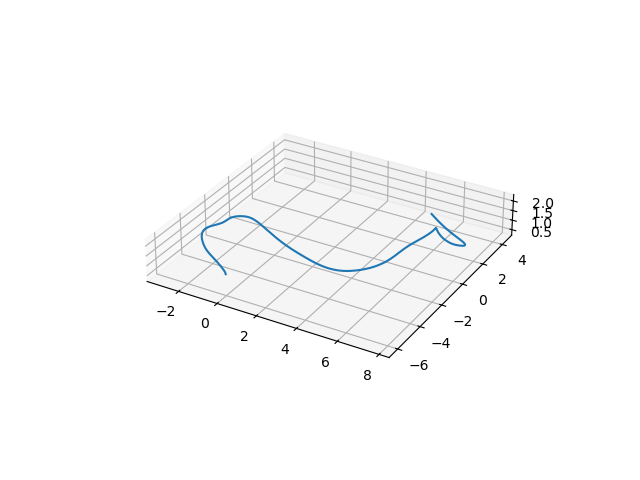

In [9]:
positions = df[ position_columns ]

Nshow = N # horizon + 1
Nshow = 870

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D( positions['p_x'][:Nshow],positions['p_y'][:Nshow],positions['p_z'][:Nshow] )
ax.set_aspect('equal')
plt.show()

In [ ]:
# with open(file_name+'.npy', 'rb') as f:
#     q_ref = np.load(f)
#     xi_ref = np.load(f)

Check Dynamics Feasibility

In [10]:
import sys
sys.path.append('..')
from traoptlibrary.traopt_utilis import se32manifse3, SE32manifSE3
from manifpy import SE3

xi_ref_mnf = [ se32manifse3(x) for x in xi_ref ]
q_ref_mnf = [ SE32manifSE3(x) for x in q_ref]
N = len(q_ref_mnf)
dt = 0.004

q = SE32manifSE3( q_ref[0] )
q_list = []
q_list.append(q)

for i in range(N):
    q = q.rplus(xi_ref_mnf[i] * dt)
    q_list.append(q)

positions_sim = np.array([ x.translation() for x in q_list ])
positions_ref = np.array([ x.translation() for x in q_ref_mnf ])

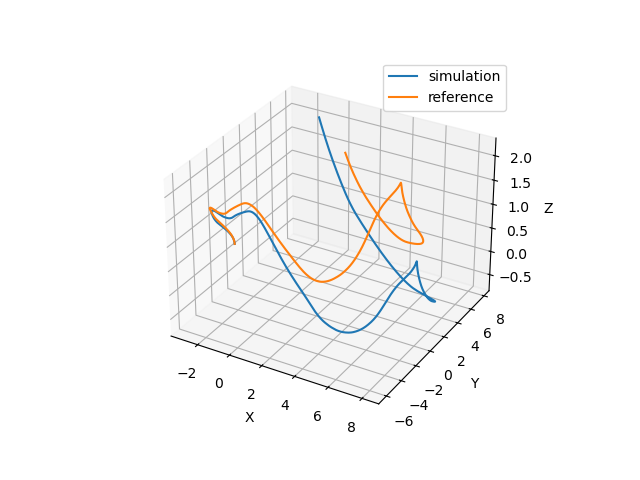

In [11]:
%matplotlib widget 
# from mpl_toolkits.mplot3d import Axes3D     

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 
ax.plot( positions_sim[:,0],positions_sim[:,1],positions_sim[:,2], label='simulation' ) 
ax.plot( positions_ref[:,0],positions_ref[:,1],positions_ref[:,2], label='reference' ) 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.legend()
plt.show()


Rerun Visualization

In [7]:
import rerun as rr
import numpy as np
import sys
import os
sys.path.append("rerun")
from rerun_loader_urdf import URDFLogger
from scipy.spatial.transform import Rotation as R

# Initialization
# os.system('export MESA_D3D12_DEFAULT_ADAPTER_NAME=NVIDIA')
# os.system('rerun --web-viewer --renderer=webgl')
rr.init("trajectory_animation", spawn=True, recording_id="drone_racing")

drone_urdf_path = "./rerun/drone.urdf"
urdf_logger = URDFLogger(drone_urdf_path, None)

urdf_logger.entity_path_prefix = f"reference/drone_urdf"
urdf_logger.log()

dt = 0.004
rr.log_file_from_path( "./rerun/random_columns_without_roof.obj" )

start_point = np.array([0.0, -6.0, 1.3])
end_point = np.array([0.0, 7.7 , 1.3])
gate_points = np.array([[-2.8, -3.6 , 1.3], [7.8, 1.6 , 1.3]])
radius = 0.2

for step in range(N):

    rr.set_time_seconds( "sim_time", dt * step )
    rr.log("setup/start_point", rr.Points3D(start_point, radii=radius))
    rr.log("setup/end_point", rr.Points3D(end_point, radii=radius))
    for i in range(gate_points.shape[0]):
        rr.log("setup/gate_point_"+str(i), rr.Points3D(gate_points[i], radii=radius))
    
    rr.log(
        f"reference/position",
        rr.Points3D(
            pos[step] #,
            # colors=vel_mapped_color,
        ),
    )

    rr.log(
        f"reference/drone_urdf",
        rr.Transform3D(
            translation=pos[step],
            rotation=rr.Quaternion(xyzw=quat_xyzw[step]),
            axis_length=1.0,
        ),
    )

    

[2025-01-08T16:35:22Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.
[2025-01-08T16:35:22Z INFO  re_sdk::spawn] A process is already listening at this address. Assuming it's a Rerun Viewer. addr=0.0.0.0:9876
[2025-01-08T16:35:22Z INFO  re_data_loader::load_file] Loading "rerun/random_columns_without_roof.obj"…
[2025-01-08T16:35:24Z ERROR re_data_loader::loader_external] Failed to execute external loader filepath="rerun/random_columns_without_roof.obj" loader="/home/chenghuailin/.local/bin/rerun-loader-urdf" reason=usage: rerun-loader-urdf [-h] [--application-id APPLICATION_ID]
                             [--recording-id RECORDING_ID]
                             [--entity-path-prefix ENTITY_PATH_PREFIX]
                             [--timeless] [--time TIME] [--sequence SEQUENCE]
                             filepath
    rerun-loader-urdf: error: unrecognized arguments: --opened-application-id trajectory_animation --opened

# Pendulum

Open rerun terminal, generate 8-shape reference

In [6]:
import rerun as rr
import numpy as np
import sys
import os
sys.path.append("rerun")
from rerun_loader_urdf import URDFLogger
from scipy.spatial.transform import Rotation as R
from manifpy import SO3

file_name = 'optimized_trajectories/path_3dpendulum_8shape'
SAVE = False

# Initialization
# os.system('export MESA_D3D12_DEFAULT_ADAPTER_NAME=NVIDIA')
# os.system('rerun --web-viewer --renderer=webgl')
rr.init("pendulum_animation", spawn=True, recording_id="3d_inverted_pendulum")

A = np.pi / 3   # Amplitude of rotation around the X-axis
B = np.pi / 2   # Amplitude of rotation around the Y-axis
omega = 2 * np.pi / 10  # Angular speed
period = 10.
dt = 0.04
N = int(2 * period / dt)
t = np.linspace(0, 2*period, N)  # Time range
theta_x = A * np.sin(omega * t)  # Rotation angle around the X-axis
theta_y = B * np.sin(2 * omega * t)  # Rotation angle around the Y-axis

# Intrinsic rotation
# rotations = [R.from_euler('XY', [tx, ty], degrees=False).as_matrix() 
#              for tx, ty in zip(theta_x, theta_y)]
# Extrinsic rotation
rotations = [R.from_euler('xy', [tx, ty], degrees=False).as_matrix() 
             for tx, ty in zip(theta_x, theta_y)] 

quaternions = [R.from_matrix(rotm).as_quat() for rotm in rotations]
rotations_mnf = [ SO3(quat) for quat in quaternions ]
# get the velocity by interpolation
omega_mnf = [ ( rotations_mnf[i+1] - rotations_mnf[i] ) / dt for i in range(N-1) ]
omega_mnf.append( omega_mnf[-1] )
omega_ref = [ x.coeffs() for x in omega_mnf ]
q_ref = rotations

if SAVE:
    with open(file_name+'.npy', 'wb') as f:
        np.save(f, q_ref)
        np.save(f, omega_ref)
        np.save(f, dt)

pendulum_length = 1.2
initial_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)
pos_tip = np.array([rotm @ initial_vector for rotm in rotations]).reshape(N, 3)

pendulum_urdf_path = "./rerun/3d_inverted_pendulum.urdf"
urdf_logger = URDFLogger(pendulum_urdf_path, None)
urdf_logger.entity_path_prefix = f"reference/pendulum_urdf"
urdf_logger.log()

rr.log_file_from_path( "./rerun/ground_floor.obj" )
# rr.log_file_from_path( "./rerun/third_sphere_x_axis.obj" )
rr.log_file_from_path( "./rerun/pendulum_animation_blueprint.rbl" )

for step in range(N):

    rr.set_time_seconds( "sim_time", dt * step )
    
    rr.log(
        f"reference/position",
        rr.Points3D(
            pos_tip[step] #,
            # colors=vel_mapped_color,
        ),
    )

    rr.log(
        f"reference/pendulum_urdf",
        rr.Transform3D(
            translation=np.array([0.,0.,0.]),
            rotation=rr.Quaternion(xyzw=quaternions[step]),
            axis_length=1.0,
        ),
    )


[2025-01-24T14:34:38Z INFO  re_sdk::spawn] A process is already listening at this address. Assuming it's a Rerun Viewer. addr=0.0.0.0:9876
[2025-01-24T14:34:38Z INFO  re_data_loader::load_file] Loading "rerun/ground_floor.obj"…
[2025-01-24T14:34:38Z INFO  re_data_loader::load_file] Loading "rerun/pendulum_animation_blueprint.rbl"…


[2025-01-24T14:34:39Z ERROR re_data_loader::loader_external] Failed to execute external loader filepath="rerun/ground_floor.obj" loader="/home/chenghuailin/.local/bin/rerun-loader-urdf" reason=usage: rerun-loader-urdf [-h] [--application-id APPLICATION_ID]
                             [--recording-id RECORDING_ID]
                             [--entity-path-prefix ENTITY_PATH_PREFIX]
                             [--timeless] [--time TIME] [--sequence SEQUENCE]
                             filepath
    rerun-loader-urdf: error: unrecognized arguments: --opened-application-id pendulum_animation --opened-recording-id 3d_inverted_pendulum
    


forward simulate the velocity for dynamics validation, and found out they actually match with each oterh

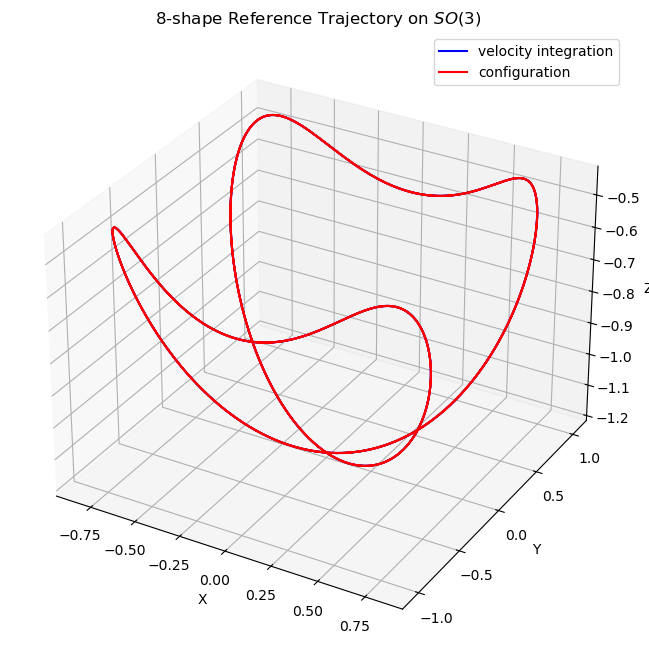

In [5]:
import matplotlib.pyplot as plt

rotm_sim = []

X = SO3.Identity()

for i in range(N):
    X = X.rplus( omega_mnf[i] * dt )
    rotm_sim.append( X.rotation())

# Define the initial pendulum vector
pendulum_length = 1.2
initial_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)

# Compute the rotated pendulum positions
rod_pos = np.array([rotm @ initial_vector for rotm in rotm_sim]).reshape(N, 3)

# Initialize the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(rod_pos[:,0], rod_pos[:,1], rod_pos[:,2], color="b", label="velocity integration")
ax.plot(pos_tip[:,0], pos_tip[:,1], pos_tip[:,2], color="r", label="configuration")
ax.set_title("8-shape Reference Trajectory on $SO(3)$")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()


generate pendulum reference 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


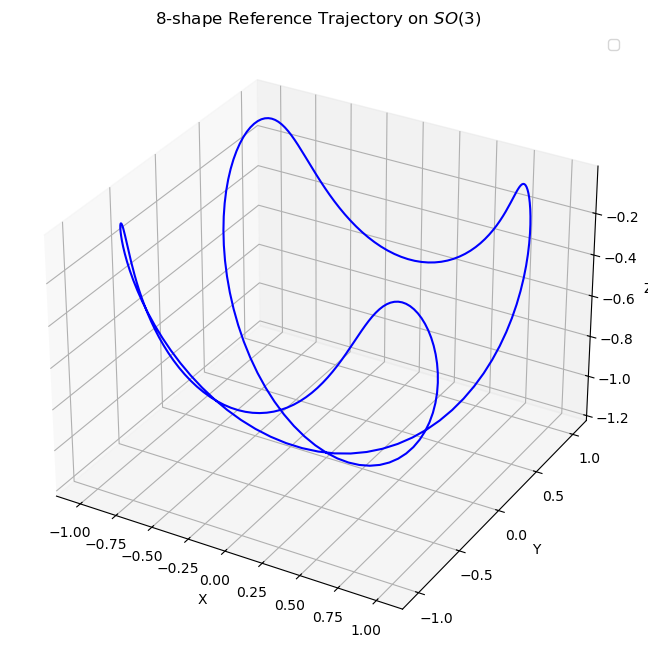

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from manifpy import SO3

file_name = 'optimized_trajectories/path_3dpendulum_8shape_tryout'
SAVE = True

A = np.pi / 3  # Amplitude of rotation around the X-axis
B = np.pi / 2   # Amplitude of rotation around the Y-axis
omega = 2 * np.pi / 10  # Angular speed
period = 10.
dt = 0.04
N = int( period / dt)
t = np.linspace(0, period, N)  # Time range
theta_x = A * np.sin(omega * t)  # Rotation angle around the X-axis
theta_y = B * np.sin(2 * omega * t)  # Rotation angle around the Y-axis

rotations = [R.from_euler('xy', [tx, ty], degrees=False).as_matrix() 
             for tx, ty in zip(theta_x, theta_y)]
quaternions = [R.from_matrix(rotm).as_quat() for rotm in rotations]

quaternions = [R.from_matrix(rotm).as_quat() for rotm in rotations]
rotations_mnf = [ SO3(quat) for quat in quaternions ]
# get the velocity by interpolation
omega_mnf = [ ( rotations_mnf[i+1] - rotations_mnf[i] ) / dt for i in range(N-1) ]
omega_mnf.append( omega_mnf[-1] )
omega_ref = [ x.coeffs() for x in omega_mnf ]
q_ref = rotations

if SAVE:
    with open(file_name+'.npy', 'wb') as f:
        np.save(f, q_ref)
        np.save(f, omega_ref)
        np.save(f, dt)

# Initialize the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Define the initial pendulum vector
pendulum_length = 1.2
initial_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)

# Compute the rotated pendulum positions
rod_pos = np.array([rotm @ initial_vector for rotm in rotations]).reshape(N, 3)

# Plot the trajectory
ax.plot(rod_pos[:,0], rod_pos[:,1], rod_pos[:,2], color="b")
ax.set_title("8-shape Reference Trajectory on $SO(3)$")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()


open rerun for swing up task with fixed pivot

In [1]:
import rerun as rr
import numpy as np
import sys
import os
sys.path.append("rerun")
from rerun_loader_urdf import URDFLogger
from scipy.spatial.transform import Rotation 
from manifpy import SO3

file_name = 'optimized_trajectories/path_3dpendulum_swingup'
SAVE = True

# Initialization
# os.system('export MESA_D3D12_DEFAULT_ADAPTER_NAME=NVIDIA')
# os.system('rerun --web-viewer --renderer=webgl')
rr.init("pendulum_animation", spawn=True, recording_id="3d_inverted_pendulum")

time_length = 2
dt = 0.025
Nsim = int( time_length / dt)

q_ref = Rotation.from_euler('x', 180., degrees=True).as_matrix()
omega_ref = np.array([0.,0.,0.])
q_ref = np.tile(q_ref, (Nsim+1,1,1))
omega_ref = np.tile(omega_ref,(Nsim+1,1))

if SAVE:
    with open(file_name+'.npy', 'wb') as f:
        np.save(f, q_ref)
        np.save(f, omega_ref)
        np.save(f, dt)

# pendulum_length = 1.2
# initial_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)
# pos_tip = np.array([rotm @ initial_vector for rotm in q_ref]).reshape(Nsim, 3)

# pendulum_urdf_path = "./rerun/3d_inverted_pendulum.urdf"
# urdf_logger = URDFLogger(pendulum_urdf_path, None)
# urdf_logger.entity_path_prefix = f"reference/pendulum_urdf"
# urdf_logger.log()

# rr.log_file_from_path( "./rerun/ground_floor.obj" )
# # rr.log_file_from_path( "./rerun/third_sphere_x_axis.obj" )
# rr.log_file_from_path( "./rerun/pendulum_animation_blueprint.rbl" )

# for step in range(N):

#     rr.set_time_seconds( "sim_time", dt * step )
    
#     rr.log(
#         f"reference/position",
#         rr.Points3D(
#             pos_tip[step] #,
#             # colors=vel_mapped_color,
#         ),
#     )

#     rr.log(
#         f"reference/pendulum_urdf",
#         rr.Transform3D(
#             translation=np.array([0.,0.,0.]),
#             rotation=rr.Quaternion(xyzw=quaternions[step]),
#             axis_length=1.0,
#         ),
#     )


[2025-01-16T21:02:17Z INFO  re_sdk_comms::server] Hosting a SDK server over TCP at 0.0.0.0:9876. Connect with the Rerun logging SDK.
[2025-01-16T21:02:17Z WARN  winit::platform_impl::linux::x11::xdisplay] error setting XSETTINGS; Xft options won't reload automatically
[2025-01-16T21:02:17Z WARN  winit::platform_impl::linux::x11::util::randr] XRandR reported that the display's 0mm in size, which is certifiably insane
[2025-01-16T21:02:17Z INFO  winit::platform_impl::linux::x11::window] Guessed window scale factor: 1
[2025-01-16T21:02:17Z INFO  re_sdk_comms::server] New SDK client connected from: 127.0.0.1:42742


[2025-01-16T21:02:17Z WARN  wgpu_hal::gles::adapter] Max vertex attribute stride unknown. Assuming it is 2048
[2025-01-16T21:02:17Z WARN  wgpu_hal::gles::adapter] Max vertex attribute stride unknown. Assuming it is 2048
[2025-01-16T21:02:17Z WARN  wgpu_hal::gles::egl] Initialized platform Wayland doesn't work with window Xlib(XlibWindowHandle { window: 8388610, visual_id: 35 })
[2025-01-16T21:02:17Z ERROR wgpu_core::device::global] surface configuration failed: incompatible window kind

thread 'main' panicked at 'Error in Surface::configure: Validation Error

Caused by:
  Invalid surface
'
wgpu-22.1.0/src/backend/wgpu_core.rs:786
stack backtrace:
   6: core::panicking::panic_fmt
   7: wgpu::backend::wgpu_core::ContextWgpuCore::handle_error_fatal


Troubleshooting Rerun: https://www.rerun.io/docs/getting-started/troubleshooting 
Report bugs: https://github.com/rerun-io/rerun/issues

Rerun caught a signal: SIGSEGV
Troubleshooting Rerun: https://www.rerun.io/docs/getting-started/troublesh

open rerun for swing up task with moving pivot

In [4]:
import rerun as rr
import numpy as np
import sys
import os
sys.path.append("rerun")
from rerun_loader_urdf import URDFLogger
from scipy.spatial.transform import Rotation 
from manifpy import SO3

file_name = 'optimized_trajectories/path_3dpendulum_swingup'
SAVE = False

# Initialization
# os.system('export MESA_D3D12_DEFAULT_ADAPTER_NAME=NVIDIA')
# os.system('rerun --web-viewer --renderer=webgl')
rr.init("pendulum_animation", spawn=True, recording_id="3d_inverted_pendulum")

time_length = 2
dt = 0.025
Nsim = int( time_length / dt)

q_ref = Rotation.from_euler('x', 180., degrees=True).as_matrix()
omega_ref = np.array([0.,0.,0.])
q_ref = np.tile(q_ref, (Nsim+1,1,1))
omega_ref = np.tile(omega_ref,(Nsim+1,1))

if SAVE:
    with open(file_name+'.npy', 'wb') as f:
        np.save(f, q_ref)
        np.save(f, omega_ref)
        np.save(f, dt)

pendulum_urdf_path = "./rerun/3d_inverted_pendulum.urdf"
urdf_logger = URDFLogger(pendulum_urdf_path, None)
urdf_logger.entity_path_prefix = f"reference/pendulum_urdf"
urdf_logger.log()

rr.log_file_from_path( "./rerun/ground_floor.obj" )
# rr.log_file_from_path( "./rerun/third_sphere_x_axis.obj" )
rr.log_file_from_path( "./rerun/pendulum_animation_blueprint.rbl" )


[2025-01-24T14:30:21Z INFO  re_sdk::spawn] A process is already listening at this address. Assuming it's a Rerun Viewer. addr=0.0.0.0:9876
[2025-01-24T14:30:21Z INFO  re_data_loader::load_file] Loading "rerun/ground_floor.obj"…
[2025-01-24T14:30:21Z INFO  re_data_loader::load_file] Loading "rerun/pendulum_animation_blueprint.rbl"…


[2025-01-24T14:30:22Z ERROR re_data_loader::loader_external] Failed to execute external loader filepath="rerun/ground_floor.obj" loader="/home/chenghuailin/.local/bin/rerun-loader-urdf" reason=usage: rerun-loader-urdf [-h] [--application-id APPLICATION_ID]
                             [--recording-id RECORDING_ID]
                             [--entity-path-prefix ENTITY_PATH_PREFIX]
                             [--timeless] [--time TIME] [--sequence SEQUENCE]
                             filepath
    rerun-loader-urdf: error: unrecognized arguments: --opened-application-id pendulum_animation --opened-recording-id 3d_inverted_pendulum
    
